In [ ]:
""" 활용 가능한 URL

# 전체 기사 X (시간 범위)
https://www.boannews.com/media/t_list.asp

# 키워드 검색 O (단어 포함 범위)
https://www.boannews.com/search/news_total.asp?search=title&find=%B7%E7%C6%AE%C5%B6

# 카테고리 분류 X (카테고리별, 시간 범위)
https://www.boannews.com/media/s_list.asp?skind=D

# 주중 많이본 뉴스 O (전체 게시글)
https://www.boannews.com/media/o_list.asp

"""

In [1]:
import re
import urllib
import requests
from bs4 import BeautifulSoup
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
from apyori import apriori
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rc
from datetime import datetime
import pandas as pd
import numpy as np

font = fm.FontProperties(fname="C:\Windows\Fonts\malgun.ttf").get_name()
rc('font', family=font)

In [2]:
class BoanNews:
    # 탐색을 위한 URL 변수들
    trends_url = "https://www.boannews.com/media/o_list.asp"
    keword_url = "https://www.boannews.com/search/news_total.asp"
    # category_url = "https://www.boannews.com/media/s_list.asp"

    # 열람을 위한 URL 변수
    post_url = "https://www.boannews.com/media/view.asp"

    # 탐색 및 열람을 위한 헤더 변수
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 \
        (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.3'
    }

    # 카테고리 확인을 위한 변수
    # category = {
    #     '1': '전체기사',
    #     '2': '오피니언',
    #     '3': '인터뷰',
    #     '4': '기사수첩',
    #     '5': '취약점 경고 및 보안 업데이트',
    #     '6': '정책',
    #     '7': '기획특집',
    #     '8': '기업뉴스',
    #     '9': 'Case Study',
    #     'A': 'Security In Movie',
    #     'B': '행사ㆍ이벤트',
    #     'C': 'TV',
    #     'D': '국제',
    #     'E': '스마트',
    #     'F': '구인구직',
    #     'G': '속보',
    #     'H': '포토뉴스',
    #     'I': '보안ㆍIT산업 동향',
    #     'J': '카드뉴스',
    #     'K': '인사ㆍ부고'
    # }


    ####################################################################################################
    # 데이터 초기화 함수들

    def __init__(self):
        # 탐색 및 열람을 위한 파라미터 변수
        self.params = dict()
        # 탐색한 뉴스리스트를 저장하는 변수
        self.news_list = []
        # 열람한 뉴스게시글을 저장하는 변수
        self.post_text = ""
        # 워드클라우드 및 네트워크 그래프를 만들기 위한 변수
        self.word_list = []


    def clear(self):
        """
        지금까지 사용한 모든 데이터를 삭제한다.
        """
        self.params = dict()
        self.news_list = []
        self.post_text = ""
        self.word_list = []


    ####################################################################################################
    # 파라미터 설정 함수들

    def _set_trends_params(self, page):
        """
        트랜드 뉴스 URL 파리미터를 설정한다.
        """
        self.params = {
            'Page': str(page)
        }
    

    def _set_keword_params(self, keword, page):
        """
        키워드 포함 뉴스 URL 파라미터를 설정한다.
        """
        encrypted_keyword = self._change_keword(keword)
        self.params = {
            'search': 'title',
            'find': encrypted_keyword,
            'Page': str(page)
        }
    

    # def _set_category_params(self, category):
    #     """
    #     카테고리별 뉴스 URL 파라미터를 설정한다.
    #     """
    #     self.params = {
    #         'skind': str(category)
    #     }
    

    def _set_post_params(self, post_index):
        """
        뉴스 게시글 URL 파라미터를 작성한다.
        """
        self.params = {
            'idx': str(post_index)
        }


    ####################################################################################################
    # 데이터 처리 함수들

    def _change_keword(self, keword):
        """
        키워드를 EUC-KR 포멧으로 바꿔준다
        """
        result = keword.encode('euc-kr')

        return result


    def _find_date(self, text):
        """
        텍스트에서 날짜를 찾아 추출한다.
        """
        regex = '[0-2][0-9][0-9][0-9]년 [0-1][0-9]월 [0-3][0-9]일'
        date = re.search(regex, text)

        if date is None:
            return None

        date = date.group()
        
        return date
    

    def _find_post_index(self, url):
        """
        저장된 데이터의 URL에서 게시글 인덱스를 찾아 추출한다.
        """
        regex = 'idx=[0-9]+'
        index = re.search(regex, url)
        index = index.group()
        index = index.replace('idx=','')
        
        return index
    
    
    # def _check_date(self, date):
    #     """
    #     입력한 날짜 형식이 올바른 검사한다.
    #     """
    #     pass
    

    ####################################################################################################
    # 뉴스 탐색용 함수들

    def search_trends(self):
        """
        주중 많이 본 뉴스를 탐색하고 관련 정보를 저장한다.
        """
        # 첫번째 페이지 설정하기
        page = 1
        while True:
            # HTML 문서 받아오기
            self._set_trends_params(page)
            response = requests.get(self.trends_url, headers=self.headers, params=self.params, verify=False)
            
            # 응답코드가 200이 아니면 반복문 종료하기
            if response.status_code != 200:
                break
            
            # 뉴스 데이터 추출하기
            soup = BeautifulSoup(response.text, 'html.parser')
            news_list = soup.select('.news_list')

            if news_list == []:
                break

            for i in range(len(news_list)):
                date = news_list[i].select_one('.news_writer').text
                date = self._find_date(date)
                
                info = news_list[i].select('a')
                
                title = info[0].text.strip()
                title = title.replace(',','.')
                summary = info[1].text.strip()
                summary = summary.replace(',','.')
                url = "boannews.com" + info[0].attrs['href']
                
                tmp_data = {
                    'category' : '주간 인기',
                    'date': date,
                    'title': title,
                    'summary': summary,
                    'url': url
                }
                # 뉴스 데이터 저장하기
                self.news_list.append(tmp_data)
                
            # 다음 페이지로 설정하기
            page += 1


    def search_keword(self, keword):
        """
        키워드가 포함된 뉴스를 탐색하고 관련 정보를 저장한다.
        """
        # 첫번째 페이지 설정하기
        page = 1
        while True:
            # HTML 문서 받아오기
            self._set_keword_params(keword, page)
            response = requests.get(self.keword_url, headers=self.headers, params=self.params, verify=False)
            
            # 응답코드가 200이 아니면 반복문 종료하기
            if response.status_code != 200 or page >= 50:
                break
            
            # 뉴스 데이터 추출하기
            soup = BeautifulSoup(response.text, 'html.parser')
            news_list = soup.select('.news_list')

            if news_list == []:
                break

            for i in range(len(news_list)):
                date = news_list[i].select_one('.news_writer').text
                date = self._find_date(date)
                
                info = news_list[i].select('a')
                
                title = info[0].text.strip()
                title = title.replace(',','.')
                summary = info[1].text.strip()
                summary = summary.replace(',','.')
                url = "boannews.com" + info[0].attrs['href']
                
                tmp_data = {
                    'category' : f'검색: {keword}',
                    'date': date,
                    'title': title,
                    'summary': summary,
                    'url': url
                }
                # 뉴스 데이터 저장하기
                self.news_list.append(tmp_data)
                
            # 다음 페이지로 설정하기
            page += 1


    # def search_category(self, keword):
    #     pass
    
    ####################################################################################################
    # 뉴스 게시글 열람 함수

    def open_post(self, index):
        """
        해당하는 뉴스 게시글의 정보를 가져온다.
        """
        post_index = self._find_post_index(self.news_list[index]['url'])
        self._set_post_params(post_index)
        response = requests.get(self.post_url, headers=self.headers, params=self.params, verify=False)
        tmp_post = BeautifulSoup(response.text, 'html.parser')
        tmp_post = str(tmp_post.select_one('#news_content'))
        tmp_post = str(tmp_post)
        tmp_post = re.sub('\<[^\>]*\>', ' ', tmp_post)
        tmp_post = re.sub('\[[^\]]*\]', ' ', tmp_post)
        tmp_post = re.sub('&.*;', ' ', tmp_post)
        tmp_post = re.sub('저작권자.*', ' ', tmp_post)
        tmp_post = tmp_post.replace('\n', ' ')
        tmp_post = tmp_post.replace('\xa0', ' ')
        tmp_post = re.sub(' +', ' ', tmp_post)
        tmp_post.strip()
        self.post_text += tmp_post


    ####################################################################################################
    # 시각화 함수들

    # def show_news_category(self):
        # data = []
        # for i in range(len(self.news_list)):
        #     data.append(self.news_list[i]['category'])
        # plt.hist(data)
        # plt.show()


    def show_news_timeline(self, date_range):
        """
        뉴스 리스트를 data_range별로 보여준다. 
        """
        data = []
        for i in range(len(self.news_list)):
            if date_range == 'day':
                data.append(str(self.news_list[i]['date']))
            elif date_range == 'month':
                data.append(str(self.news_list[i]['date'])[:9])
            elif date_range == 'year':
                data.append(str(self.news_list[i]['date'])[:5])
            else:
                return None
        data = Counter(data)
        date = data.keys()
        freq = data.values()
        plt.xticks(rotation=45)
        plt.plot(date, freq)


    def show_title_include(self, keword):
        """
        뉴스 제목안에 해당 키워드가 포함된 양을 보여줍니다.
        """
        yes = 0
        for i in range(len(self.news_list)):
            if keword in self.news_list[i]['title']:
                yes += 1
        no = len(self.news_list) - yes
        data = [yes, no]
        label = ['yes', 'no']
        print(data)
        plt.bar(label, data)
        plt.show()


    def show_news_network(self):
        okt = Okt()

        dataset = []
        for i in range(len(self.news_list)):
            dataset.append(okt.nouns(re.sub('가-힣a-zA-Z\s', '', self.news_list[i]['title'])))

        # for i in range(len(self.news_list)):
        #     dataset.append(okt.nouns(re.sub('가-힣a-zA-Z', '', self.news_list[i]['summary'])))

        dataset = [word for word in dataset if len(word) > 1]
        print(dataset)

        result = (list(apriori(dataset, min_support=0.01)))

        df=pd.DataFrame(result)
        df['length'] = df['items'].apply(lambda x: len(x))
        df = df[(df['length']==2) & (df['support'] >= 0.01)].sort_values(by='support', ascending=False)
        print(df.head(10))
        
        G = nx.Graph()
        ar = (df['items'])
        G.add_edges_from(ar)

        pr = nx.pagerank(G)
        nsize = np.array([v for v in pr.values()])
        nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))
        pos = nx.kamada_kawai_layout(G)
        
        plt.figure(figsize=(16,12)); plt.axis('off')
        nx.draw_networkx(G, font_family=font, font_size=10,
                         pos=pos, node_color=list(pr.values()), node_size=nsize, width=2.0,
                         alpha=0.7, edge_color='.5', cmap=plt.cm.YlGn)


    def show_post_wordcloud(self, *except_keword):
        """
        지금까지 열람한 뉴스 게시글들을 워드클라우드로 보여준다.
        """
        okt = Okt()
        self.word_list += okt.nouns(self.post_text)
        self.word_list = [word for word in self.word_list if len(word) > 1]
        count = Counter(self.word_list)
        for i in except_keword:
            del count[i]
        wc = WordCloud(font_path='malgun', width=400, height=400, scale=2.0, max_font_size=250)
        gen = wc.generate_from_frequencies(count)
        plt.figure()
        plt.imshow(gen)
    

    ####################################################################################################
    # 데이터 저장 함수들

    def save_news_list(self, *file_name):
        """
        지금까지 탐색한 뉴스리스트를 CSV로 저장한다.
        """
        now = datetime.now()
        now = now.strftime('%Y-%m-%d-%H%M%S')
        with open(f'./news_list_{now}.csv', 'w') as f:
            field = ','.join(str(field) for field in self.news_list[0].keys()) + '\n'
            f.write(field)
            record = '\n'.join([','.join(map(str,record.values())) for record in self.news_list]) 
            f.write(record)


    def save_post_text(self, *file_name):
        """
        지금까지 열람한 뉴스게시글을 TXT로 저장한다.
        """
        now = datetime.now()
        now = now.strftime('%Y-%m-%d-%H%M%S')
        with open(f'./post_text_{now}.txt', 'w') as f:
            f.write(self.post_text)

    def load_new_list(self, file_name):
        """
        뉴스리스트 파일을 불러온다.
        """
        # with open(f'./{file_name}.csv', 'r'):
        # 판다스로 가능하면 판다스로 진행하자.
            

    def load_post_text(self, file_name):
        """
        뉴스게시글 파일일을 불러온다.
        """
        pass
    

    ####################################################################################################
    # 사용법 도움말 함수

    def show_help(self):
        with open('./show_help.txt', 'r') as f:
            lines = f.readlines()
            for line in lines:
                print(line, end='')
    

c:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.boannews.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.boannews.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.boannews.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\urllib3\conn

[['플레이', '랜섬', '웨어', '갱단', '미국', '오클랜드', '시', '빼', '정보', '공개'], ['로얄', '랜섬', '웨어', '피해자', '달러', '요구'], ['랜섬', '웨어', '통해', '재', '확산', '중', '조직', '유포'], ['대형', '위성', '통신', '업체', '디시', '네트워크', '랜섬', '웨어', '공격'], ['미국', '연방', '보안', '청', '랜섬', '웨어', '공격'], ['보안', '업체', '비트디펜더', '모탈콤뱃', '랜섬', '웨어', '복구', '도구', '무료', '공개'], ['등장', '익스플로잇', '프레임워크', '록빗', '랜섬웨어', '개발'], ['보안', '리포트', '제조업', '랜섬', '웨어', '피해', '일파', '파', '보안', '솔루션', '필수', '템'], ['부활', '클롭', '랜섬웨어', '제로', '데이', '취약점', '공격'], ['피해자', '지불', '랜섬', '웨어', '건의', '몸값', '향후', '건의', '공격', '원동력'], ['해킹', '범죄', '사건', '추적', '체포', '보안', '전문가'], ['퓨어', '크립', '터', '멀웨어', '정부', '기관', '각종', '멀웨어', '감염'], ['취약점', '악용', '해킹', '피해', '한국', '기업', '기관', '곳', '추정'], ['유명', '농산품', '업체', '돌', '랜섬', '웨어', '공격', '생산', '중단'], ['이스라엘', '대학', '발생', '랜섬', '웨어', '공격', '삼중', '협박', '삼중', '동기'], ['센티넬', '사이버', '위협', '및', '동향', '보고서', '발표'], ['그니', '베르', '랜섬웨어', '재', '확산', '엣지', '및', '크롬', '브라우저', '파일', '유포'], ['랜섬', '웨어', '격자', '작년', '해', '대부분', '취약점', '공략'], ['하드

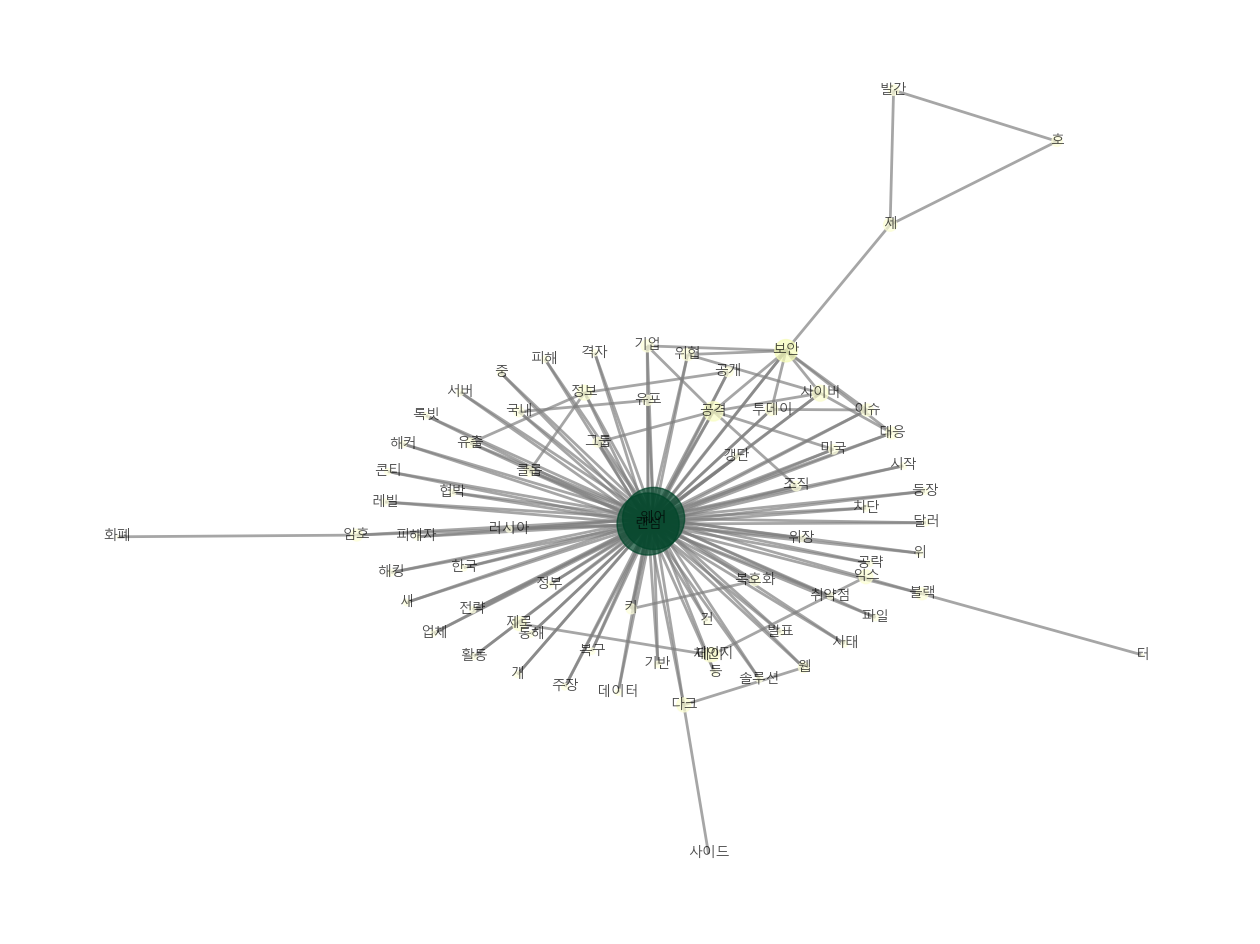

In [30]:
bn = BoanNews()
# bn.search_trends()
bn.search_keword('랜섬웨어')
bn.show_news_network()

***

In [ ]:
bn = BoanNews()
bn.show_help()

In [ ]:
bn.search_keword('루트킷')

In [ ]:
bn.show_title_include('루트킷')

In [ ]:
bn.news_list

In [ ]:
bn.show_news_timeline('year')

In [ ]:
bn.clear()
bn.search_trends()
for i in range(10):
    bn.open_post(i)

In [ ]:
bn.show_post_wordcloud('보안','사이버','정보','정보보호','기업')

In [ ]:
bn.post_text

In [ ]:
Counter(bn.word_list)

In [ ]:
bn.save_news_list()

In [ ]:
bn.save_post_text()

# 추가하면 좋을 내용



문제점 1. 한 번 했던 크롤링을 또 하게 된다.
> 저장된 데이터를 다시 불러오기
>
> 난이도: 하

<br/>

문제점 2. 관련 게시글을 일일이 찾아다니기 귀찮다.
> 게시글 간의 연관성 파악을 위해 연관분석 네트워크 그래프 메소드 만들기
>
> 난이도: 상~중

<br/>

문제점 3. 원하는 날짜 범위의 뉴스 리스트만 필요할 수 있다.
> 탐색시 원하는 날짜 범위의 정보를 가져오기
>
> 난이도: 하